Import Dependencies
-----

In [0]:
from os import makedirs

import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torchvision import datasets, transforms
from torchvision.utils import save_image

from torchsummary import summary

Autoencoder Object
----


In [0]:
class Autoencoder(nn.Module):
    """
    Autoencoder where the decoder structure simply mirrors the encoder structure
    """

    def __init__(self, n_input, h_units, non_lin):
        """
        Decoder is designed to model the
        :param n_input: no. of input units to the network
        :param h_units: list of size n_layers
        """
        super(Autoencoder, self).__init__()
        layer_list = []
        h_layers = len(h_units)

        def add_layer_and_act(n_inp, n_hidden, nl_type): return [nn.Linear(n_inp, n_hidden), self.non_lin(nl_type)]

        # Build Encoder Layers
        layer_list.extend(add_layer_and_act(n_input, h_units[0], non_lin))

        if len(h_units)>1:
            for i in range(1, h_layers):
                layer_list.extend(add_layer_and_act(h_units[i-1], h_units[i], non_lin))

        # Build Decoder Layers
        if len(h_units) > 1:
            for i in range(h_layers-1, 0, -1):
                layer_list.extend(add_layer_and_act(h_units[i], h_units[i-1], non_lin))

        # Build Output layer
        non_lin = 'sigmoid' # Output sigmoidal regardless of network non-linearities
        layer_list.extend(add_layer_and_act(h_units[0], n_input, non_lin))

        self.block = nn.Sequential(*layer_list)

    def forward(self, x):
        return self.block(x)

    def non_lin(self, nl_type='sigmoid'):
        """
        Simply plugs in a predefined non-linearity from a dictionary to be used throughout the network
        :param nl_type: type based on predefined types. Defaults to sigmoid on wrong type.
        :return:
        """
        nl = {'sigmoid': nn.Sigmoid(), 'tanh': nn.Tanh(), 'relu': nn.ReLU()}
        try:
            return nl[nl_type]
        except:
            print("non linearity type not found. Defaulting to sigmoid.")
            return nl['sigmoid']


Test Model Object
---

In [3]:
model = Autoencoder(784, [256, 128], 'sigmoid').cuda()
summary(model, input_size=(1, 784))
print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         200,960
           Sigmoid-2               [-1, 1, 256]               0
            Linear-3               [-1, 1, 128]          32,896
           Sigmoid-4               [-1, 1, 128]               0
            Linear-5               [-1, 1, 256]          33,024
           Sigmoid-6               [-1, 1, 256]               0
            Linear-7               [-1, 1, 784]         201,488
           Sigmoid-8               [-1, 1, 784]               0
Total params: 468,368
Trainable params: 468,368
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.79
Estimated Total Size (MB): 1.81
----------------------------------------------------------------
Autoencoder(
  (block): Sequential(
    (0

Weight Init and Train Methods
----


In [0]:
def init_weights(m, mean=0, std=.3):
    """
    Initializes the weights of linear layers of m using random normal distribution with mean=0 and variance = 0.2
    :param m:
    :return:
    """

    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight, mean, std)
        torch.nn.init.normal_(m.bias, mean, std)


def train(dataloader, iters = 20):
    """
    Trains the 'model' (autoencoder) on the given dataloader and saves the last batch of images
    :param dataloader: The autoencoder is trained on the dataloader
    :param iters: iterations for training
    :return:
    """
    loss_list = []
    makedirs(f'./{loss_type}_Images', exist_ok=True)
    for itr in range(iters):
        av_itr_loss = 0.0
        for batch_id, (x, _) in enumerate(dataloader):
            optimizer.zero_grad()
            x = x.cuda()
            # x = (x>0.5).float() * 1
            x = x.view(batch_size, -1)
            # print(x[0])
            z = model(x)
            # print((z==1).sum())
            batch_loss = loss(z, x)
            batch_loss.backward()
            optimizer.step()
            av_itr_loss += (1/batch_size)*batch_loss.item()
        save_image(z.view(batch_size, 1, 28, 28), "./{}_Images/generated_image_itr_{}.png".format(loss_type, itr))
        if itr == iters-1:
            save_image(z.view(batch_size,1,28,28),"./{}_generated_image_itr_{}.png".format(loss_type,itr))
        print("Epoch {}: Loss={}".format(itr+1, av_itr_loss))
        loss_list.append(av_itr_loss)
    return loss_list


def plot_training_curve():
    """
    Plots the loss list
    """
    plt.plot(loss_list)
    plt.ylabel(f"{loss_type}")
    plt.xticks([i+1 for i in range(20)])
    plt.xlabel("Epochs")
    plt.show()



Run Training
----


Training on MSE Loss:
Epoch 1: Loss=1.9606238268315792
Epoch 2: Loss=1.2076950437622145
Epoch 3: Loss=1.104364866623655
Epoch 4: Loss=1.0477961028227583
Epoch 5: Loss=1.0148502392694354
Epoch 6: Loss=0.9781471453607082
Epoch 7: Loss=0.9445457305992022
Epoch 8: Loss=0.9221306134131737
Epoch 9: Loss=0.8993958813953213
Epoch 10: Loss=0.8775020111352205
Epoch 11: Loss=0.856535050785169
Epoch 12: Loss=0.8366701625636779
Epoch 13: Loss=0.8175574112101458
Epoch 14: Loss=0.7993037842097692
Epoch 15: Loss=0.7816632477333769
Epoch 16: Loss=0.7635411414667033
Epoch 17: Loss=0.7478900897549465
Epoch 18: Loss=0.7330610797507688
Epoch 19: Loss=0.7189321384648792
Epoch 20: Loss=0.7054778364254162


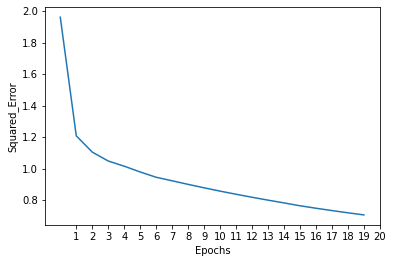

In [10]:
lr = 0.7
batch_size = 64

d_train = datasets.MNIST('./data/mnist', train=True, download=True, transform=transforms.ToTensor())
# d_test  = datasets.MNIST('./data/mnist', train=False, download=True, transform=transforms.ToTensor())

train_dataloader = torch.utils.data.DataLoader(d_train, batch_size=batch_size, shuffle=True, drop_last=True)
# test_dataloader  = torch.utils.data.DataLoader(d_test,  batch_size=batch_size, shuffle=True, drop_last=True)

# Creating Autoencoder of as specified in Question 1
model = Autoencoder(784, [256, 128], 'sigmoid')

# Initializing autoencoder weights as specified in Question 2
model.apply(init_weights)
model = model.cuda()
model.train()

print("Training on MSE Loss:")
# Using Squared Error Loss as in Question 3
loss_type = "Squared_Error"
# loss = lambda x, z: (x-z).pow(2).sum(dim=1).mean() # Manual MSELoss implementation with mean over batch of sum(X-Z)^2
loss = nn.MSELoss() # MSE either does mean of everything or sum of everything I think
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
loss_list = train(train_dataloader)
plot_training_curve()

print("\nTraining on Cross Entropy Loss:")
# Using Cross Entropy Error as in Question 4
lr = 0.1 # Need a higher lr for CE to converge
loss_type = "Cross_Entropy"
model.apply(init_weights) # Reinitializing weights
model.train()
# loss = lambda x, z: (x*torch.log1p(z) + (1-x) * torch.log1p(1-z)).sum(dim=1).mean()
loss = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
loss_list = train(train_dataloader)
plot_training_curve()